[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239464-lesson-1-streaming)

# Streaming

## Review

In module 2, covered a few ways to customize graph state and memory.
 
We built up to a Chatbot with external memory that can sustain long-running conversations. 

## Goals

This module will dive into `human-in-the-loop`, which builds on memory and allows users to interact directly with graphs in various ways. 

To set the stage for `human-in-the-loop`, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

## Streaming

LangGraph is built with [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution. 

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

GROQ_API_KEY:  ········


Note that we use `RunnableConfig` with `call_model` to enable token-wise streaming. This is [only needed with python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). We include in case you are running this notebook in CoLab, which will use python 3.x. 

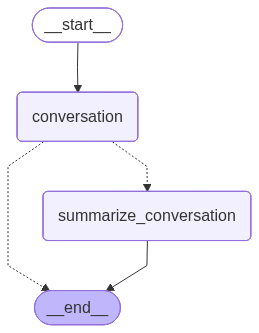

In [5]:
from IPython.display import Image, display
from typing import Literal

# Using the Groq LLM integration instead of OpenAI
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM (Groq)
model = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)

# State
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is a summary, include it
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    # Call the Groq model
    response = model.invoke(messages, config)
    return {"messages": response}

# Summarization function
def summarize_conversation(state: State):
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This is a summary of the conversation so far: {summary}\n\n"
            "Extend the summary by including the new messages above:"
        )
    else:
        summary_message = "Create a concise summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Keep only the two most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    messages = state["messages"]
    if len(messages) > 6:
        return "summarize_conversation"
    return END

# Define the workflow graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile workflow
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

# Display the graph
display(Image(graph.get_graph().draw_mermaid_png()))


### Streaming full state

Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results. 
 
LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [7]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="Hi, I'm Giovanni Giorgio, but everybody calles me Giorgio. How to learn Real Analysis on my own?")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Nice to meet you, Giorgio. Learning Real Analysis on your own can be challenging, but with a solid plan and dedication, you can achieve it. Here\'s a step-by-step guide to help you get started:\n\n1. **Prerequisites**: Make sure you have a strong foundation in:\n\t* Calculus (I, II, and III)\n\t* Linear Algebra\n\t* Mathematical proofs and reasoning\n2. **Textbooks**: Choose a comprehensive textbook that suits your learning style. Some popular options include:\n\t* "Real Analysis" by Royden and Fitzpatrick\n\t* "Real and Complex Analysis" by Walter Rudin\n\t* "Introduction to Real Analysis" by Robert G. Bartle and Donald R. Sherbert\n3. **Online Resources**:\n\t* MIT OpenCourseWare: Real Analysis (18.100)\n\t* Khan Academy: Real Analysis\n\t* 3Blue1Brown (YouTube): Real Analysis animations\n4. **Video Lectures**:\n\t* 3Blue1Brown (YouTube): Real Analysis\n\t* Harvard University: Real Analysis (Math 112)\n\t* UC Berkeley: Real Analysis (M

Let's now just print the state update.

In [8]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hello again, Lance! Welcome back! I was just chatting with Giorgio about learning Real Analysis. How about you? What brings you here today? Do you have any questions or topics you'd like to discuss?


Now, we can see `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [10]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="Hi I'm Pedro. Could you tell me the best way to learn control theory?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! It's nice to meet you. Is there something I can help you with or would you like to chat?
================================ Human Message =================================

Hi I'm Pedro. Could you tell me the best way to learn control theory?
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! It's nice to meet you. Is there something I can help you with or would you like to chat?
================================ Human Message =================================

Hi I'm Pedro. Could you tell me the best way to learn control theory?
================================== Ai Message ==============

### Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [11]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the greatest football team of all time, the Tottenham Spurs")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conver

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [12]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the greatest football team of all time, the Tottenham Spurs")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='lc_run--cacff0f5-d834-4d5c-a5de-29fb99cb67b5')}
{'chunk': AIMessageChunk(content='A', additional_kwargs={}, response_metadata={}, id='lc_run--cacff0f5-d834-4d5c-a5de-29fb99cb67b5')}
{'chunk': AIMessageChunk(content=' passionate', additional_kwargs={}, response_metadata={}, id='lc_run--cacff0f5-d834-4d5c-a5de-29fb99cb67b5')}
{'chunk': AIMessageChunk(content=' Tottenham', additional_kwargs={}, response_metadata={}, id='lc_run--cacff0f5-d834-4d5c-a5de-29fb99cb67b5')}
{'chunk': AIMessageChunk(content=' fan', additional_kwargs={}, response_metadata={}, id='lc_run--cacff0f5-d834-4d5c-a5de-29fb99cb67b5')}
{'chunk': AIMessageChunk(content=',', additional_kwargs={}, response_metadata={}, id='lc_run--cacff0f5-d834-4d5c-a5de-29fb99cb67b5')}
{'chunk': AIMessageChunk(content=' I', additional_kwargs={}, response_metadata={}, id='lc_run--cacff0f5-d834-4d5c-a5de-29fb99cb67b5')}
{'chunk': AIMessageChunk(content=' see',

As you see above, just use the `chunk` key to get the `AIMessageChunk`.

In [13]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the greatest football team of all time, the Tottenham Spurs")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|A| passionate| Tottenham| fan|,| I| see|.| While| opinions| about| the| greatest| football| team| of| all| time| vary|,| Tottenham| Hot|sp|ur| has| a| rich| history| and| a| loyal| fan| base|.| However|,| it|'s| essential| to| acknowledge| that| the| concept| of| the| "|g|reatest| team| of| all| time|"| is| subjective| and| often| influenced| by| personal| biases|,| gener|ational| differences|,| and| team| lo|y|alties|.

|That| being| said|,| Tottenham| has| had| some| remarkable| seasons| and| achievements| throughout| their| history|.| Here| are| a| few| notable| examples|:

|1|.| **|The| Double| Winners| (|196|0|-|196|1|)**|:| Under| the| management| of| Bill| Nicholson|,| Tottenham| became| the| first| British| team| to| win| the| European| Cup| (|now| Champions| League|)| and| the| domestic| league| title| in| the| same| season|.| This| achievement| is| still| celebrated| by| Spurs| fans| today|.
|2|.| **|The| UEFA| Cup| Winners| (|197|2|,| |198|4|)**|:| Tottenham| won| the| UEFA

### Streaming with LangGraph API

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

The LangGraph API [supports editing graph state](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation). 

In [14]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [ ]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

Let's [stream `values`](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/), like before.

In [ ]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    print(event)

The streamed objects have: 

* `event`: Type
* `data`: State

In [13]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Multiply 2 and 3' additional_kwargs={} response_metadata={} id='c3ec872a-99a1-4eec-bcb6-a04973f48ac5'
content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'total_tokens': 151, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f64f290af2', 'id': 'chatcmpl-CSqw6HYoyCI7z2AuKAAfSTQGbvzla', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='lc_run--c91028e7-7a0a-4746-a4f5-edcff5380abc-0' tool_calls=[{'name': 'multiply', 'args

There are some new streaming mode that are only supported via the API.

For example, we can [use `messages` mode](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/) to better handle the above case!

This mode currently assumes that you have a `messages` key in your graph, which is a list of messages.

All events emitted using `messages` mode have two attributes:

* `event`: This is the name of the event
* `data`: This is data associated with the event

In [14]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/metadata
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial


We can see a few events: 

* `metadata`: metadata about the run
* `messages/complete`: fully formed message 
* `messages/partial`: chat model tokens

You can dig further into the types [here](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages).

Now, let's show how to stream these messages. 

We'll define a helper function for better formatting of the tool calls in messages.

In [15]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata and response_metadata.get("finish_reason"):
                    print(f"Response Metadata: Finish Reason - {response_metadata['finish_reason']}")                    
        print("-" * 50)

Metadata: Run ID - 019a0358-57dc-76f9-bc63-633eee467a86
--------------------------------------------------
Tool Calls:
Tool Call ID: call_mDtKBiuzkpN5ITWykhEFN0XU, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_mDtKBiuzkpN5ITWykhEFN0XU, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_mDtKBiuzkpN5ITWykhEFN0XU, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_mDtKBiuzkpN5ITWykhEFN0XU, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_mDtKBiuzkpN5ITWykhEFN0XU, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_mDtKBiuzkpN5ITWykhEFN0XU, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: cal

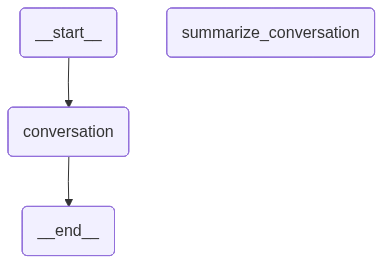

In [18]:
from IPython.display import Image, display

from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

model = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)

# State
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is a summary, then we add it
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = model.invoke(messages, config)
    return {"messages": response}

# Summarize conversation
def summarize_conversation(state: State):

    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This is a summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the two most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile the graph
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

# Display the graph diagram
display(Image(graph.get_graph().draw_mermaid_png()))


In [19]:
# Create a thread
config = {"configurable": {"thread_id": "11"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="Hi, I'm Jack.")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content="Hello Jack! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 41, 'total_tokens': 67, 'completion_time': 0.044941437, 'prompt_time': 0.002987759, 'queue_time': 0.056132961, 'total_time': 0.047929196}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--5c44b461-be72-4ce7-813e-a75de204ae13-0', usage_metadata={'input_tokens': 41, 'output_tokens': 26, 'total_tokens': 67})}}


In [20]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="Hi! I'm Jack")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hello again, Jack! Welcome back. How's your day going so far?


In [21]:
# Start conversation, again
config = {"configurable": {"thread_id": "22"}}

# Start conversation
input_message = HumanMessage(content="Hey there! I'm Jack, how are you?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

Hey there! I'm Jack, how are you?
---------------------------------------------------------------------------
================================ Human Message =================================

Hey there! I'm Jack, how are you?
================================== Ai Message ==================================

Hello Jack, I'm doing well, thanks for asking. It's nice to meet you. Is there something I can help you with or would you like to chat?
---------------------------------------------------------------------------


In [22]:
config = {"configurable": {"thread_id": "77"}}

input_message = HumanMessage(content="Give me a quick summary of the Iraq War.")

async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    node = event["metadata"].get("langgraph_node", "unknown")
    event_type = event["event"]
    name = event["name"]
    print(f"[Node: {node}] Event Type: {event_type} | Name: {name}")

[Node: unknown] Event Type: on_chain_start | Name: LangGraph
[Node: conversation] Event Type: on_chain_start | Name: conversation
[Node: conversation] Event Type: on_chat_model_start | Name: ChatGroq
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatGroq
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatGroq
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatGroq
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatGroq
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatGroq
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatGroq
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatGroq
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatGroq
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatGroq
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatGroq
[Node: conversation] Event Type: on_chat_model_stream | Name: ChatGroq
[Node: conversation

In [23]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "44"}}
input_message = HumanMessage(content="Give me a quick summary of the Iraq War.")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='lc_run--a0ec66f6-be54-49d2-b644-9fa39acdd104')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='lc_run--a0ec66f6-be54-49d2-b644-9fa39acdd104')}
{'chunk': AIMessageChunk(content=' Iraq', additional_kwargs={}, response_metadata={}, id='lc_run--a0ec66f6-be54-49d2-b644-9fa39acdd104')}
{'chunk': AIMessageChunk(content=' War', additional_kwargs={}, response_metadata={}, id='lc_run--a0ec66f6-be54-49d2-b644-9fa39acdd104')}
{'chunk': AIMessageChunk(content=',', additional_kwargs={}, response_metadata={}, id='lc_run--a0ec66f6-be54-49d2-b644-9fa39acdd104')}
{'chunk': AIMessageChunk(content=' also', additional_kwargs={}, response_metadata={}, id='lc_run--a0ec66f6-be54-49d2-b644-9fa39acdd104')}
{'chunk': AIMessageChunk(content=' known', additional_kwargs={}, response_metadata={}, id='lc_run--a0ec66f6-be54-49d2-b644-9fa39acdd104')}
{'chunk': AIMessageChunk(content=' as', addit

In [24]:
config = {"configurable": {"thread_id": "55"}}
input_message = HumanMessage(content="Give me a quick summary of the Iraq War.")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| Iraq| War|,| also| known| as| the| Second| Gulf| War| or| Operation| Iraqi| Freedom|,| was| a| conflict| that| lasted| from| |200|3| to| |201|1|.| Here|'s| a| brief| summary|:

|**|Ca|uses|:|**
|The| war| began| on| March| |20|,| |200|3|,| when| a| coalition| of| forces| led| by| the| United| States|,| with| support| from| the| United| Kingdom| and| other| countries|,| invaded| Iraq|.| The| primary| reason| for| the| invasion| was| the| claim| that| Iraq|'s| dictator|,| Saddam| Hussein|,| possessed| weapons| of| mass| destruction| (|W|MD|s|)| and| had| ties| to| terrorist| organizations|,| including| al|-Qaeda|.

|**|Initial| Invasion| (|200|3|):|**
|The| coalition| forces| quickly| over|ran| Iraq|,| and| Saddam| Hussein|'s| government| was| topp|led|.| The| capital| city|,| Baghdad|,| fell| on| April| |9|,| |200|3|.| Saddam| Hussein| went| into| hiding| and| was| eventually| captured| in| December| |200|3|.

|**|Ins|urg|ency| and| Occupation| (|200|3|-|200|7|):|**
|After| the| i